### EDA: step by step

- Enviroment Setting (anomaly_eda)
- ToyCar Overview
  - ToyCar Train
  - ToyCar Train + Test

In [16]:
!pip install librosa matplotlib seaborn pandas scikit-learn

In [17]:
toycar_dir = "../../datasets/dev/"
classes = ["ToyCar" , "ToyTrain", "bearing", "fan", "gearbox", "slider", "valve"]

# /home/uturtle/datasets/data_eda/unziped/dev/ToyCar/attributes_00.csv
# first attribute - file_name (no domain, label, all train data normal data)
# Task: Eject wav file and convert them linear spectogram.
#   1. we First EDA ToyCar
#       1. Eject ToyCar wav files 
#       2. Convert linear spectogram
#       3. Make Distribution spectogram
#       4. Dimension Decrease (PCA...)

In [18]:
import pandas as pd
import os

# ToyCar 데이터셋 경로 설정
toycar_dir = "../../datasets/dev/ToyCar"
attributes_file = os.path.join(toycar_dir, "attributes_00.csv")

# CSV 파일 읽기
df = pd.read_csv(attributes_file)

# 열 이름 출력
print("CSV 파일의 열 이름:", df.columns.tolist())


CSV 파일의 열 이름: ['file_name', 'd1p', 'd1v', 'd2p', 'd2v', 'd3p', 'd3v']


In [19]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns

# 데이터셋 경로 및 클래스 설정
datasets = "../../datasets/dev"
classes = ["ToyCar", "ToyTrain", "bearing", "fan", "gearbox", "slider", "valve"]

# stft hyperparameter
n_fft = 512
hop_length = 256

# ToyCar 데이터셋 경로 설정
toycar_dir = os.path.join(datasets, "ToyCar")
attributes_file = os.path.join(toycar_dir, "attributes_00.csv")

# Step 1: ToyCar wav 파일 및 메타데이터 추출
def load_toycar_data(attributes_file):
    df = pd.read_csv(attributes_file)
    
    filenames = df['file_name'].tolist()
    labels = ['anomaly' if 'anomaly' in name else 'normal' for name in filenames]
    
    # 전체 파일 경로 생성
    file_paths = [os.path.join(datasets, f) for f in filenames]
    
    return file_paths, labels

# Step 2: wav 파일을 선형 스펙트로그램으로 변환
def wav_to_linear_spectrogram(file_paths, labels, n_fft=512, hop_length=256, window='hann'):
    spectrograms = []
    valid_labels = []
    for path, label in zip(file_paths, labels):
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
            S_mag = np.abs(S)
            spectrograms.append(S_mag)
            valid_labels.append(label)
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    return spectrograms, valid_labels

# Step 1: 데이터 로드
file_paths, labels = load_toycar_data(attributes_file)
print(f"Loaded {len(file_paths)} ToyCar audio files.")

# Step 2: wav 파일을 선형 스펙트로그램으로 변환
spectrograms, valid_labels = wav_to_linear_spectrogram(file_paths, labels, n_fft=n_fft, hop_length=hop_length)
print(f"Converted {len(spectrograms)} wav files to linear spectrograms.")

# 정상 및 이상 데이터 분리
spectrograms_normal = [S for S, label in zip(spectrograms, valid_labels) if label == 'normal']
spectrograms_anomaly = [S for S, label in zip(spectrograms, valid_labels) if label == 'anomaly']

Loaded 1200 ToyCar audio files.


Converted 1200 wav files to linear spectrograms.


In [20]:
print(len(spectrograms_normal))
print(len(spectrograms_anomaly))

1100
100


Plotting 2 Normal and 2 Anomaly Spectrograms


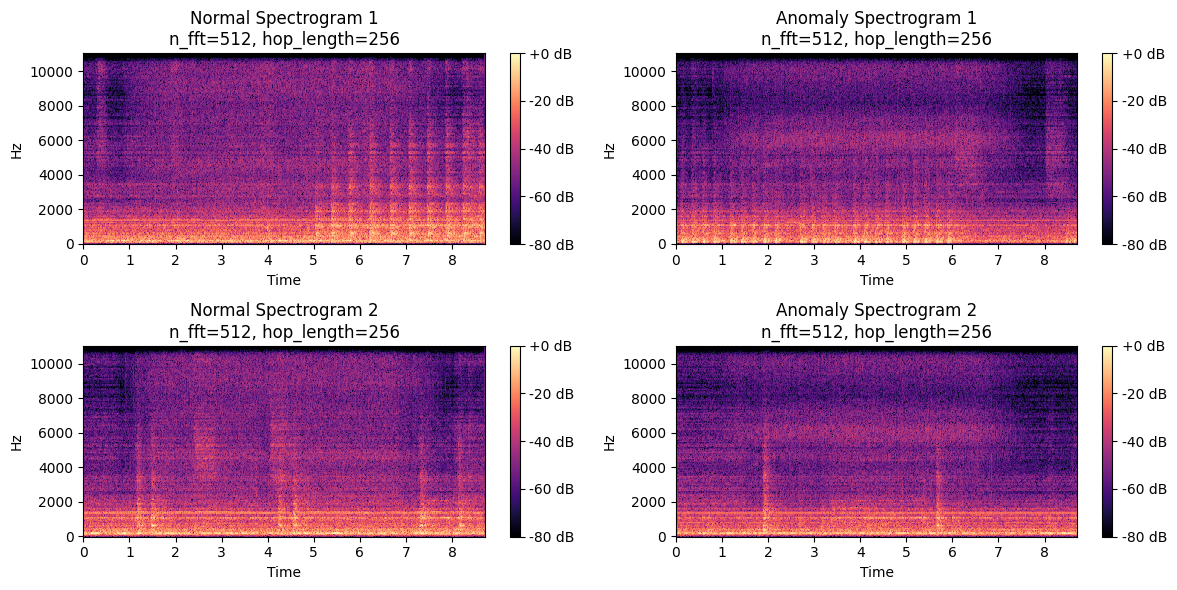

In [21]:
# 최대 5 spectrograms from each class
num_plots = 2
spectrograms_normal_samples = spectrograms_normal[:num_plots]
spectrograms_anomaly_samples = spectrograms_anomaly[:num_plots]

# Function to plot spectrograms side by side
def plot_normal_anomaly_spectrograms(norm_spectrograms, anom_spectrograms, hop_length, n_fft):
    # Determine the number of rows based on the maximum number of plots in either class
    rows = max(len(norm_spectrograms), len(anom_spectrograms))
    
    # Create a figure with 2 columns: Normal and Anomaly
    plt.figure(figsize=(12, 3 * rows))
    
    for i in range(rows):
        # Plot Normal Spectrogram
        plt.subplot(rows, 2, 2*i + 1)
        if i < len(norm_spectrograms):
            S_db = librosa.amplitude_to_db(norm_spectrograms[i], ref=np.max)
            librosa.display.specshow(S_db, hop_length=hop_length, x_axis='time', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Normal Spectrogram {i + 1}\nn_fft={n_fft}, hop_length={hop_length}')
        else:
            plt.axis('off')  # Hide axis if no spectrogram to plot
        
        # Plot Anomaly Spectrogram
        plt.subplot(rows, 2, 2*i + 2)
        if i < len(anom_spectrograms):
            S_db = librosa.amplitude_to_db(anom_spectrograms[i], ref=np.max)
            librosa.display.specshow(S_db, hop_length=hop_length, x_axis='time', y_axis='linear')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f'Anomaly Spectrogram {i + 1}\nn_fft={n_fft}, hop_length={hop_length}')
        else:
            plt.axis('off')  # Hide axis if no spectrogram to plot
    
    plt.tight_layout()
    plt.show()


# Plot 5 Normal and 5 Anomaly Spectrograms side by side
if len(spectrograms_normal_samples) > 0 or len(spectrograms_anomaly_samples) > 0:
    print(f"Plotting {len(spectrograms_normal_samples)} Normal and {len(spectrograms_anomaly_samples)} Anomaly Spectrograms")
    plot_normal_anomaly_spectrograms(spectrograms_normal_samples, spectrograms_anomaly_samples, hop_length, n_fft)
else:
    print("No spectrograms to plot.")

In [ ]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress warnings from librosa (optional)
warnings.filterwarnings('ignore')

# -----------------------------
# Configuration Parameters
# -----------------------------
DATASETS_DIR = "../../datasets/dev"  # Path to the datasets directory
CLASS_NAME = "ToyCar"                # Class to analyze
ATTRIBUTES_FILE = os.path.join(DATASETS_DIR, CLASS_NAME, "attributes_00.csv")  # Path to the attributes CSV
N_FFT_VALUES = [1024, 786, 512, 384, 256, 128, 64]   # n_fft values
HOP_LENGTH_VALUES = [256, 192, 128, 96, 64, 32, 16]  # hop_length values

# -----------------------------
# Step 1: Load Dataset
# -----------------------------
def load_dataset(attributes_file, datasets_dir):
    if not os.path.isfile(attributes_file):
        raise FileNotFoundError(f"Attributes file not found: {attributes_file}")

    df = pd.read_csv(attributes_file)
    filenames = df['file_name'].tolist()
    labels = ['anomaly' if 'anomaly' in name.lower() else 'normal' for name in filenames]
    file_paths = [os.path.join(datasets_dir, f) for f in filenames]

    return file_paths, labels

# -----------------------------
# Step 2: Define Hyperparameter Combinations
# -----------------------------
def define_hyperparameter_combinations(n_fft_values, hop_length_values):
    combinations = []
    for n_fft in n_fft_values:
        for hop_length in hop_length_values:
            combinations.append({'n_fft': n_fft, 'hop_length': hop_length})
    return combinations

# -----------------------------
# Step 3: Select Multiple Audio Samples
# -----------------------------
def select_multiple_samples(file_paths, labels, max_samples=3):
    normal_paths = [file_paths[i] for i, label in enumerate(labels) if label == 'normal'][:max_samples]
    anomaly_paths = [file_paths[i] for i, label in enumerate(labels) if label == 'anomaly'][:max_samples]

    if not normal_paths:
        raise ValueError("No normal samples found in the dataset.")
    if not anomaly_paths:
        raise ValueError("No anomaly samples found in the dataset.")

    return normal_paths, anomaly_paths

# -----------------------------
# Step 4: Compute Spectrogram
# -----------------------------
def compute_spectrogram(y, n_fft, hop_length, window='hann'):
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    S_mag = np.abs(S)
    S_db = librosa.amplitude_to_db(S_mag, ref=np.max)
    return S_db

# -----------------------------
# Step 5: Plot Spectrograms
# -----------------------------
def plot_comparison_grid(normal_spectrograms, anomaly_spectrograms, hyperparameters, num_samples):
    num_sets = len(hyperparameters)
    num_cols = num_samples * 2  # Each sample has Normal and Anomaly
    plt.figure(figsize=(22, 3 * num_sets))  # Adjusted figure size

    for i in range(num_sets):
        params = hyperparameters[i]
        n_fft = params['n_fft']
        hop_length = params['hop_length']

        for j in range(num_samples):
            # Plot Normal Spectrogram
            plt.subplot(num_sets, num_cols, j * 2 + 1 + i * num_cols)
            librosa.display.specshow(normal_spectrograms[j][i],
                                     hop_length=hop_length,
                                     x_axis='time',
                                     y_axis='linear',
                                     cmap='magma')
            plt.colorbar(format='%+2.0f dB')
            if j == 0:
                plt.title(f'Normal\nn_fft={n_fft}, hop_length={hop_length}')

            # Plot Anomaly Spectrogram
            plt.subplot(num_sets, num_cols, j * 2 + 2 + i * num_cols)
            librosa.display.specshow(anomaly_spectrograms[j][i],
                                     hop_length=hop_length,
                                     x_axis='time',
                                     y_axis='linear',
                                     cmap='magma')
            plt.colorbar(format='%+2.0f dB')
            if j == 0:
                plt.title(f'Anomaly\nn_fft={n_fft}, hop_length={hop_length}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Comparison of Normal and Anomaly Spectrograms with Varying STFT Hyperparameters', fontsize=16)
    plt.show()

# -----------------------------
# Main Execution Flow
# -----------------------------
def main():
    # Step 1: Load Dataset
    try:
        file_paths, labels = load_dataset(ATTRIBUTES_FILE, DATASETS_DIR)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return
    print(f"Loaded {len(file_paths)} audio files from '{CLASS_NAME}' class.")

    # Step 2: Define Hyperparameter Combinations
    hyperparameter_combinations = define_hyperparameter_combinations(N_FFT_VALUES, HOP_LENGTH_VALUES)
    print(f"\nDefined {len(hyperparameter_combinations)} Hyperparameter Combinations")

    # Step 3: Select Multiple Audio Samples
    try:
        normal_paths, anomaly_paths = select_multiple_samples(file_paths, labels, max_samples=3)
    except Exception as e:
        print(f"Error selecting samples: {e}")
        return
    print(f"\nSelected {len(normal_paths)} Normal Samples and {len(anomaly_paths)} Anomaly Samples.")

    # Step 4: Compute Spectrograms for Each Hyperparameter Combination
    normal_spectrograms = []
    anomaly_spectrograms = []

    # Process Normal Samples
    for normal_path in normal_paths:
        try:
            y_normal, sr_normal = librosa.load(normal_path, sr=None)
            print(f"\nProcessing Normal Sample: {normal_path}")
            spectrograms_for_sample = []
            for idx, params in enumerate(hyperparameter_combinations, 1):
                n_fft = params['n_fft']
                hop_length = params['hop_length']
                S_db_normal = compute_spectrogram(y_normal, n_fft, hop_length)
                spectrograms_for_sample.append(S_db_normal)
                print(f"  Combination {idx}: n_fft={n_fft}, hop_length={hop_length}")
            normal_spectrograms.append(spectrograms_for_sample)
        except Exception as e:
            print(f"Error processing normal sample {normal_path}: {e}")

    # Process Anomaly Samples
    for anomaly_path in anomaly_paths:
        try:
            y_anomaly, sr_anomaly = librosa.load(anomaly_path, sr=None)
            print(f"\nProcessing Anomaly Sample: {anomaly_path}")
            spectrograms_for_sample = []
            for idx, params in enumerate(hyperparameter_combinations, 1):
                n_fft = params['n_fft']
                hop_length = params['hop_length']
                S_db_anomaly = compute_spectrogram(y_anomaly, n_fft, hop_length)
                spectrograms_for_sample.append(S_db_anomaly)
                print(f"  Combination {idx}: n_fft={n_fft}, hop_length={hop_length}")
            anomaly_spectrograms.append(spectrograms_for_sample)
        except Exception as e:
            print(f"Error processing anomaly sample {anomaly_path}: {e}")

    # Step 5: Plot Spectrogram Comparison Grid
    print("\nPlotting Spectrogram Comparison Grid...")
    plot_comparison_grid(normal_spectrograms, anomaly_spectrograms, hyperparameter_combinations, num_samples=len(normal_paths))

if __name__ == "__main__":
    main()


In [29]:
import os
import pandas as pd
import librosa
import numpy as np
import warnings

# Suppress warnings from librosa (optional)
warnings.filterwarnings('ignore')

# -----------------------------
# Configuration Parameters
# -----------------------------
DATASETS_DIR = "../../datasets/dev"  # Path to the original datasets directory
EXTRACT_DIR = "./extract_stft/dev"                    # Base directory to save spectrogram data
N_FFT_VALUES = [1024, 786, 512, 384, 256, 128, 64]   # n_fft values
HOP_LENGTH_VALUES = [256, 192, 128, 96, 64, 32, 16]  # hop_length values

# -----------------------------
# Step 1: Define Hyperparameter Combinations
# -----------------------------
def define_hyperparameter_combinations(n_fft_values, hop_length_values):
    combinations = []
    for n_fft in n_fft_values:
        for hop_length in hop_length_values:
            combinations.append({'n_fft': n_fft, 'hop_length': hop_length})
    return combinations

# -----------------------------
# Step 2: Compute and Save Spectrogram
# -----------------------------
def compute_save_spectrogram(y, sr, n_fft, hop_length, save_dir, file_name, label):
    """
    Computes the spectrogram and saves it as a .npy file.

    Args:
        y (np.ndarray): Audio time series.
        sr (int): Sampling rate of the audio.
        n_fft (int): Number of FFT components.
        hop_length (int): Number of samples between successive frames.
        save_dir (str): Directory to save the spectrogram.
        file_name (str): Original audio file name for clarity.
        label (str): Label to distinguish between 'normal' and 'anomaly'.
    """
    # Compute spectrogram in dB scale
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann')
    S_mag = np.abs(S)
    S_db = librosa.amplitude_to_db(S_mag, ref=np.max)

    # Save the spectrogram as a .npy file
    filename = f"{label}_{file_name}.npy"
    filepath = os.path.join(save_dir, filename)
    np.save(filepath, S_db)
    # print(f"Saved spectrogram: {filepath}")

# -----------------------------
# Step 3: Prepare Directory Structure
# -----------------------------
def prepare_save_directory(base_dir, class_name, data_split, n_fft, hop_length):
    """
    Prepares the directory structure for saving spectrogram data.

    Args:
        base_dir (str): Base directory to save the data.
        class_name (str): Name of the class (e.g., 'ToyCar').
        data_split (str): Data split type ('train' or 'test').
        n_fft (int): FFT size.
        hop_length (int): Hop length for STFT.

    Returns:
        str: Path to the specific directory for saving the spectrogram.
    """
    hyper_dir = f"n_fft_{n_fft}_hop_length_{hop_length}"
    save_dir = os.path.join(base_dir, class_name, data_split, hyper_dir)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

# -----------------------------
# Main Execution Flow
# -----------------------------
def main():
    # Step 1: Define Hyperparameter Combinations
    hyperparameter_combinations = define_hyperparameter_combinations(N_FFT_VALUES, HOP_LENGTH_VALUES)
    print(f"\nDefined {len(hyperparameter_combinations)} Hyperparameter Combinations")

    # Step 2: Iterate through each class and process files
    class_names = [d for d in os.listdir(DATASETS_DIR) if os.path.isdir(os.path.join(DATASETS_DIR, d))]
    for class_name in class_names:
        print(f"\nProcessing class: {class_name}")

        # Define paths for train and test directories in the original datasets
        class_train_dir = os.path.join(DATASETS_DIR, class_name, "train")
        class_test_dir = os.path.join(DATASETS_DIR, class_name, "test")

        # Step 3: Process each split (train and test)
        for data_split in ["train", "test"]:
            data_dir = class_train_dir if data_split == "train" else class_test_dir
            if not os.path.isdir(data_dir):
                print(f"Warning: {data_split} directory not found for class {class_name}. Skipping...")
                continue

            # Step 4: Process each file in the data split directory
            audio_files = [f for f in os.listdir(data_dir) if f.endswith(".wav")]
            for file_name in audio_files:
                file_path = os.path.join(data_dir, file_name)
                
                # Load audio file
                try:
                    y, sr = librosa.load(file_path, sr=None)
                    # print(f"Processing file '{file_name}' in {data_split} split of class '{class_name}'")
                    
                    # Step 5: Process each hyperparameter combination
                    for params in hyperparameter_combinations:
                        n_fft = params['n_fft']
                        hop_length = params['hop_length']
                        
                        # Prepare directory for saving this spectrogram
                        save_dir = prepare_save_directory(EXTRACT_DIR, class_name, data_split, n_fft, hop_length)
                        
                        # Compute and save the spectrogram
                        compute_save_spectrogram(y, sr, n_fft, hop_length, save_dir, file_name, label=data_split)

                except Exception as e:
                    print(f"Error processing file '{file_name}': {e}")

if __name__ == "__main__":
    main()



Defined 49 Hyperparameter Combinations

Processing class: ToyCar

Processing class: gearbox

Processing class: valve

Processing class: bearing
Error processing file 'section_00_source_train_normal_0469_pro_A_vel_12_loc_D.wav': 1970394 requested and 150496 written
Error processing file 'section_00_source_train_normal_0980_pro_B_vel_16_loc_D.wav': [Errno 28] No space left on device
Error processing file 'section_00_source_train_normal_0090_pro_A_vel_12_loc_A.wav': [Errno 28] No space left on device
Error processing file 'section_00_source_train_normal_0517_pro_B_vel_8_loc_A.wav': [Errno 28] No space left on device
Error processing file 'section_00_source_train_normal_0401_pro_A_vel_4_loc_D.wav': [Errno 28] No space left on device
Error processing file 'section_00_source_train_normal_0639_pro_B_vel_8_loc_B.wav': [Errno 28] No space left on device
Error processing file 'section_00_source_train_normal_0365_pro_A_vel_12_loc_C.wav': [Errno 28] No space left on device
Error processing file '

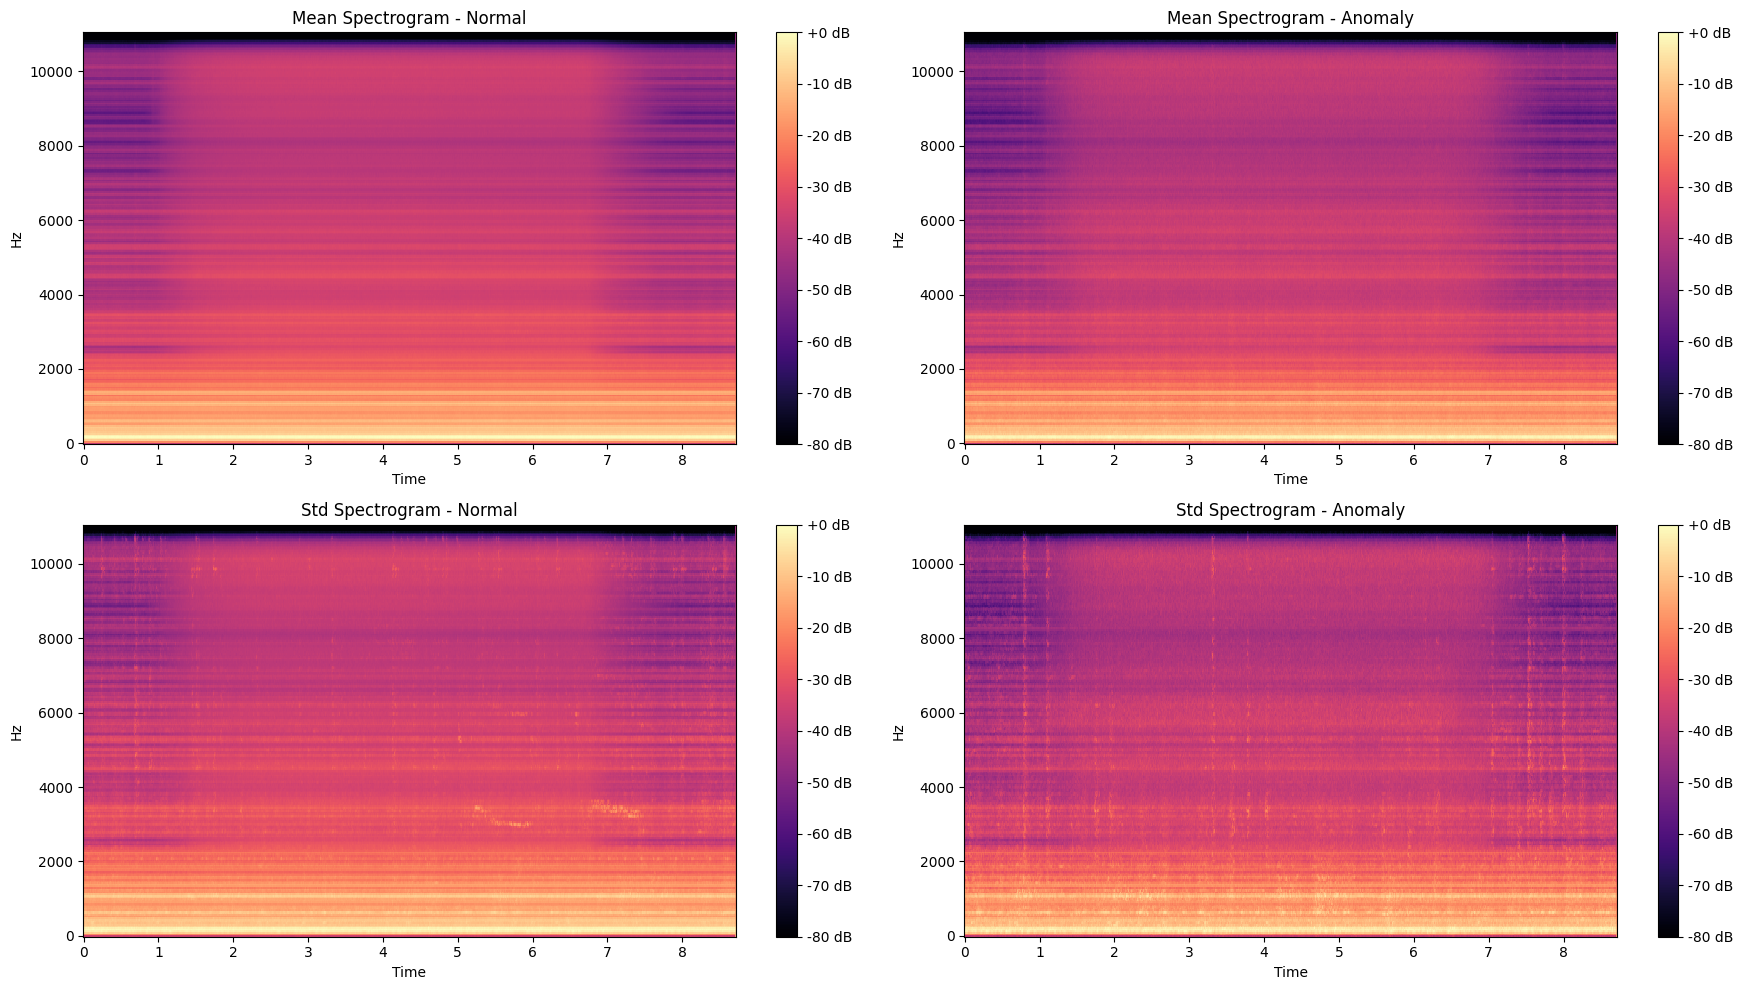

In [23]:
# Step 3: 스펙트로그램 평균 및 표준편차 계산
def calculate_mean_std_spectrograms(spectrograms):
    S_stack = np.stack(spectrograms, axis=0)  # (num_samples, freq_bins, time_frames)
    S_mean = np.mean(S_stack, axis=0)
    S_std = np.std(S_stack, axis=0)
    return S_mean, S_std

# Step 4: 스펙트로그램 평균 및 표준편차 비교 시각화
def plot_spectrogram_comparison(S_mean_normal, S_std_normal, S_mean_anomaly, S_std_anomaly):
    plt.figure(figsize=(18, 10))

    # 정상 데이터 평균 스펙트로그램
    plt.subplot(2, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(S_mean_normal, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mean Spectrogram - Normal')

    # 이상 데이터 평균 스펙트로그램
    plt.subplot(2, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(S_mean_anomaly, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mean Spectrogram - Anomaly')

    # 정상 데이터 표준편차 스펙트로그램
    plt.subplot(2, 2, 3)
    librosa.display.specshow(librosa.amplitude_to_db(S_std_normal, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Std Spectrogram - Normal')

    # 이상 데이터 표준편차 스펙트로그램
    plt.subplot(2, 2, 4)
    librosa.display.specshow(librosa.amplitude_to_db(S_std_anomaly, ref=np.max), sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Std Spectrogram - Anomaly')

    plt.tight_layout()
    plt.show()

# Step 3: 평균 및 표준편차 계산
S_mean_normal, S_std_normal = calculate_mean_std_spectrograms(spectrograms_normal)
S_mean_anomaly, S_std_anomaly = calculate_mean_std_spectrograms(spectrograms_anomaly)

# Step 4: 스펙트로그램 평균 및 표준편차 비교 시각화
plot_spectrogram_comparison(S_mean_normal, S_std_normal, S_mean_anomaly, S_std_anomaly)